In [ ]:
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from datetime import datetime
import os
import matplotlib.pyplot as plt

### 1. generate the dataset

In [6]:
def generate_polynomial_dataset(n, k, num_samples=1000, seed=None):
    pattern = torch.tensor([1, -1], dtype=torch.long)
    coeffs = pattern.repeat(k // 2)
    X = torch.randint(0, 10, (num_samples, n))
    indices = torch.randperm(n)[:k].long() 
    y = X[:, indices] @ coeffs               
    CLS_ID = 10
    cls_column = torch.full((num_samples, 1), CLS_ID, dtype=torch.long)
    X = torch.cat([cls_column, X], dim=1)

    return X, y

### 2. write different model architectures for comparison

In [7]:
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        x = x.float()
        return self.net(x).squeeze(1)

class TransformerRegressor(nn.Module):
    def __init__(self, vocab_size, seq_len, d_model=8, nhead=4, ff_dim=32):
        super().__init__()
        self.cls_token_id = 10
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, seq_len, d_model))

        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, ff_dim, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)

        self.regressor = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, 1),
        )

    def forward(self, x):
        x = x.long()
        seq_len = x.size(1)
        pos_emb = self.pos_embedding[:, :seq_len, :]  # trim to match input length
        x = self.embedding(x) + pos_emb
        x = self.encoder(x)

        cls_token = x[:, 0, :]  # Extract the [CLS] token (shape: [batch_size, d_model])
        # cls_token = self.batchnorm(cls_token)

        return self.regressor(cls_token).squeeze(1)


### 3. write the traning script

In [8]:
def train_model(model, dataloader, epochs=100, lr=1e-2, device = "cuda", debug=False):
    model.to(device)
    model.train()
    criterion = nn.MSELoss()
    lr = 2e-2 if model == FFNN else 4e-2
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []

    for i in range(epochs):
        total_loss = 0
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(x_batch)
            y_batch = y_batch.float()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * len(x_batch)
        avg_loss = total_loss / len(dataloader.dataset)
        if i % 20 == 0 and debug:
            print(avg_loss)
        losses.append(avg_loss)
    return losses


### 4. specify different configurations for n, k and run experiments.

In [ ]:
configs = [(50,6), (80,6), (120, 6)]
num_runs = 10
epochs = 4000

vocab_size = 10
batch_size = 512

for n, k in configs:
    print(f"Running config n={n}, k={k}")
    ffnn_losses_all = []
    transformer_losses_all = []

    for run in tqdm(range(num_runs)):
        X, y  = generate_polynomial_dataset(n, k)
        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        # FFNN
        ffnn = FFNN(n+1, k)
        ffnn_losses = train_model(ffnn, dataloader, epochs, debug=True)
        ffnn_losses_all.append(ffnn_losses)
        print(f"final loss for  FFNN is {ffnn_losses[-1]}.")

        # Transformer
        transformer = TransformerRegressor(vocab_size=vocab_size+1, seq_len=n+1, nhead=8)
        transformer_losses = train_model(transformer, dataloader, epochs, debug=True)
        transformer_losses_all.append(transformer_losses)
        print(f"final loss for transformer is {transformer_losses[-1]}.")
        
        

        if (run + 1) % 40 == 0:
            print(f"  Run {run+1}/{num_runs} coplteted")
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join("../numeric_log", f"run_{timestamp}")
    file_path_f = os.path.join(run_dir, f"ffnn_lr_{n}_{k}.npy")
    np.save(file_path_f, np.array(ffnn_losses_all))

    file_path_t = os.path.join(run_dir, f"transformer_lr_{n}_{k}.npy")
    np.save(file_path_t, np.array(transformer_losses_all))

### 5. visualize the loss trends for both models under all configurations

In [ ]:
def init_plot_params():
        plt.rcParams['savefig.dpi'] = 600

        plt.rcParams['font.family'] = 'STIXGeneral'

        plt.rcParams['legend.fontsize'] = 35
        plt.rcParams['font.size'] = 40
        plt.rcParams['axes.labelsize'] = 48 
        plt.rcParams['legend.fontsize'] = 42
        plt.rcParams['xtick.labelsize'] = 40 
        plt.rcParams['ytick.labelsize'] = 40

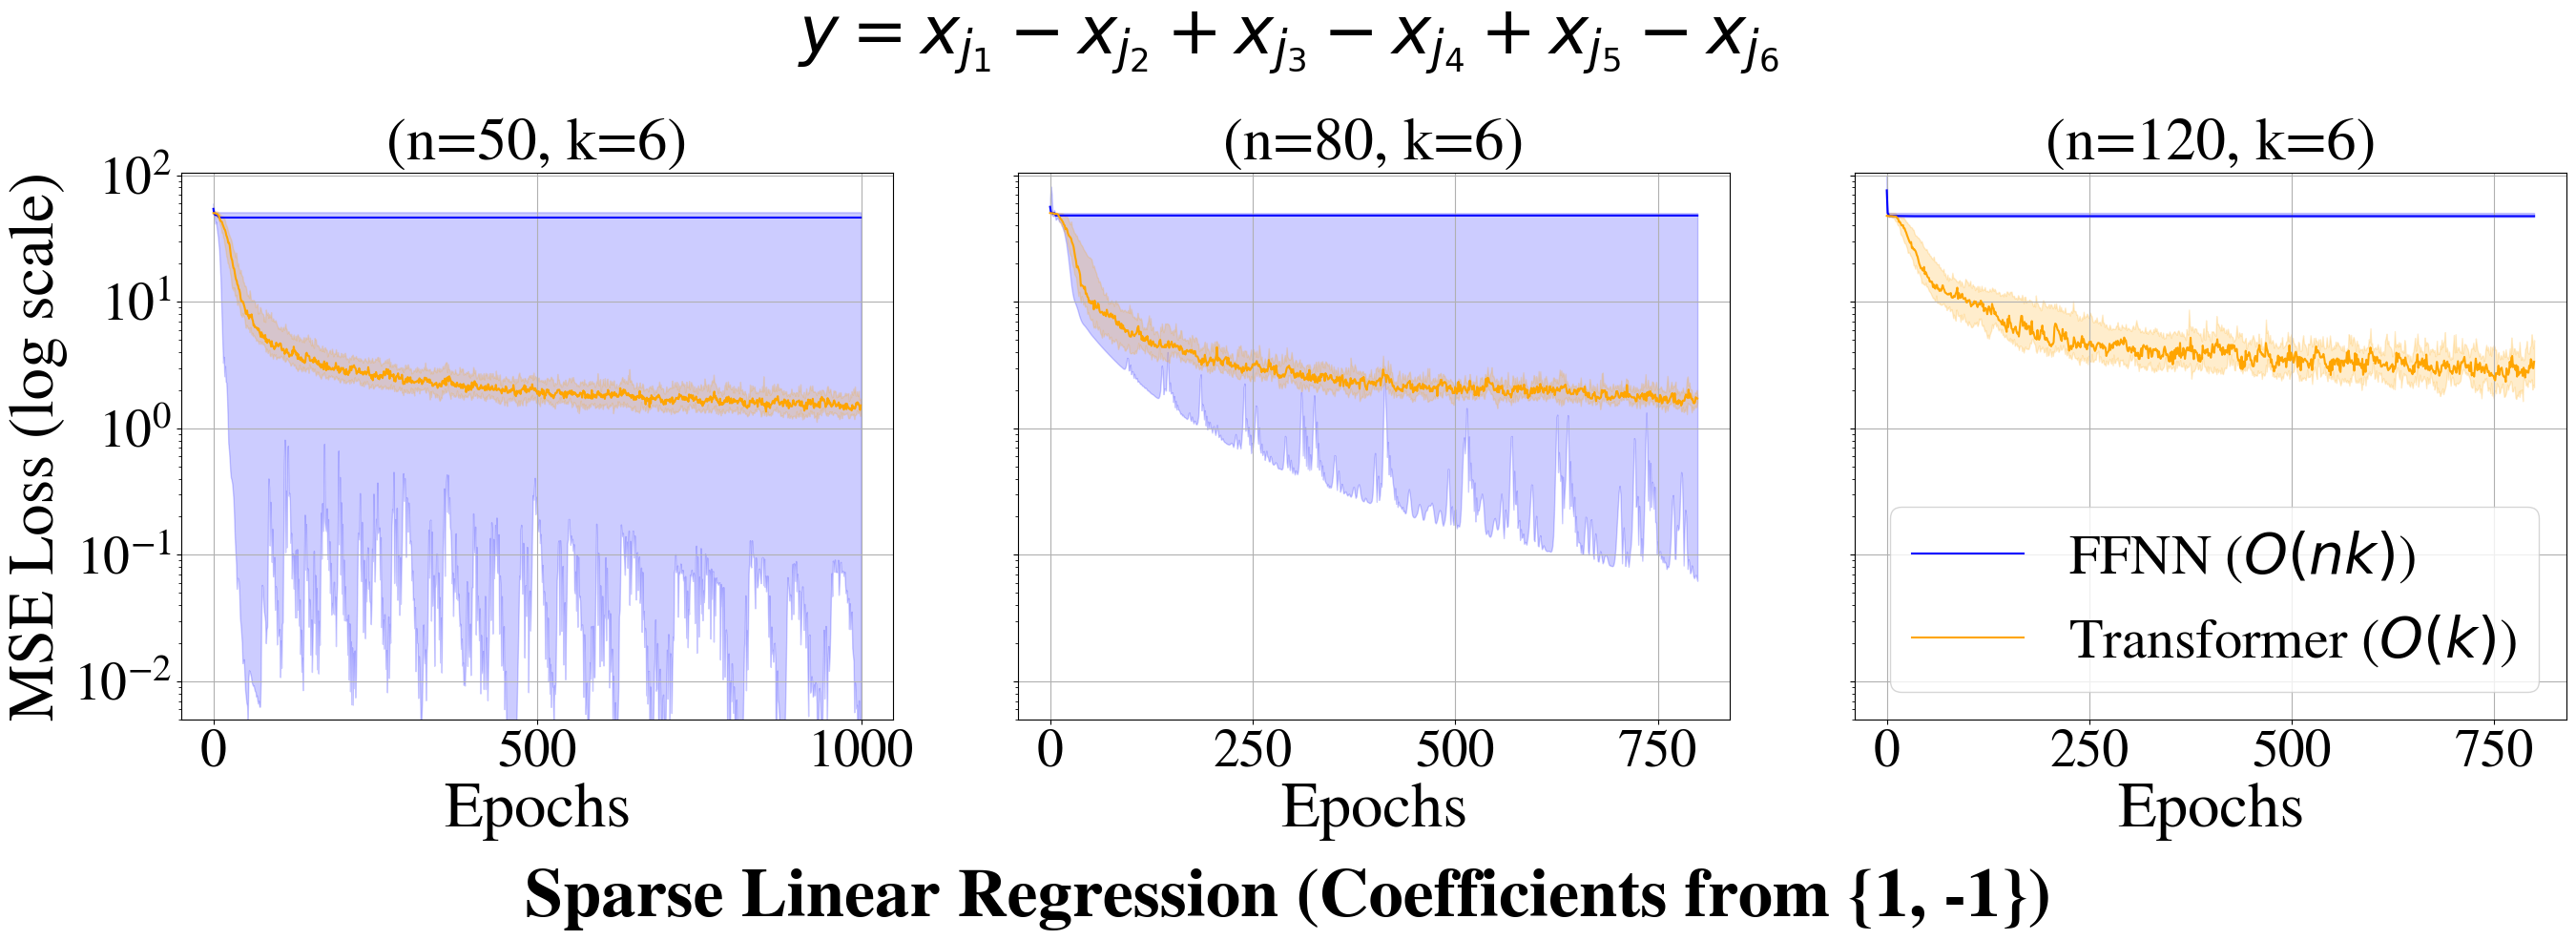

In [ ]:


# === Function to generate the synthetic polynomial description ===
def generate_polynomial_string(n, k):
    indices = torch.arange(6).long() + 1
    coeffs = torch.Tensor([1, -1 ,1, -1, 1, -1]).long()
    coeffs = ["", "-", "+", "-", "+", "-"]
    terms = [f"{coef}x_{{j_{idx}}}" for coef, idx in zip(coeffs, indices)]
    return " ".join(terms)

# === Configurations ===
configs = [
    {"n": 50, "k": 6},
    {"n": 80, "k": 6},
    {"n": 120, "k": 6},
]
init_plot_params()
fig, axes = plt.subplots(1, 3, figsize=(28, 9.5), sharey=True)

for ax, cfg in zip(axes, configs):
    n, k = cfg["n"], cfg["k"]
    poly_str = generate_polynomial_string(n, k)

    # Load losses
    ffnn_losses = np.load(f"../numeric_log/classification/ffnn_lr_{n}_{k}.npy") 
    transformer_losses = np.load(f"../numeric_log/classification/transformer_lr_{n}_{k}.npy")
    sample_step = 4
    ffnn_losses = ffnn_losses[::sample_step]
    transformer_losses = transformer_losses[::sample_step]

    epochs = ffnn_losses.shape[1]

    # Quartile stats
    def get_stats(losses):
        q1 = np.percentile(losses, 20, axis=0)
        q2 = np.percentile(losses, 50, axis=0)
        q3 = np.percentile(losses, 80, axis=0)
        return q1, q2, q3

    f_q1, f_q2, f_q3 = get_stats(ffnn_losses)
    t_q1, t_q2, t_q3 = get_stats(transformer_losses)

    epochs = np.arange(epochs)

    # Plot FFNN
    ax.plot(epochs, f_q2, label="FFNN ($O(nk)$)", color="blue")
    ax.fill_between(epochs, f_q1, f_q3, color="blue", alpha=0.2)

    # Plot Transformer
    ax.plot(epochs, t_q2, label="Transformer ($O(k)$)", color="orange")
    ax.fill_between(epochs, t_q1, t_q3, color="orange", alpha=0.2)

    ax.set_yscale("log")
    ax.set_ylim(bottom=5e-3)
    ax.set_xlabel("Epochs")
    ax.set_title(f"(n={n}, k={k})", fontsize=45)
    ax.grid(True)

axes[0].set_ylabel("MSE Loss (log scale)")
axes[2].legend(loc="lower right")
plt.suptitle(f"$y = {poly_str}$", fontsize=50, fontweight="bold")
plt.figtext(0.5, -0.02, "Sparse Linear Regression (Coefficients from {1, -1})", ha='center', fontsize=52, fontweight="bold")
plt.tight_layout()
plt.subplots_adjust(top=0.8)
plt.savefig("lr.pdf", bbox_inches='tight')
plt.show()
